# Objectives

Within this example, we estimate GRAIL's trajectory using ODF Doppler measurements as the data source. To achieve a high-fidelity estimation suitable for research analysis, the script follows this methodology:
1.  **Data Loading & Pre-processing:** Loading raw ODF files, filtering for the specific arc, and compressing Doppler data to 60s intervals to optimize computational load.
2.  **Environment Setup:** Constructing a precise lunar environment, incorporating the `gggrx1200` gravity field (truncated to order 500) and solid body tides from the Earth and Sun.
3.  **Dynamical Modelling:** Configuring the propagation with high-precision accelerations, including panelled radiation pressure models for both Solar and Lunar sources (thermal emission and albedo).
4.  **Estimation:** Performing a least-squares fit to estimate the spacecraft initial state, radiation pressure coefficients, and maneuvers.
5.  **Validation:** Computing pre- and post-fit residuals and analyzing the trajectory difference w.r.t. the SPICE reference ephemeris.

## Important Remarks
- Before running this script, please make sure you are using **Tudatpy v1.0 or above**.
- Running the example automatically triggers the download of all required kernels and data files if they are not found locally
(trajectory and orientation kernels for the MRO spacecraft, atmospheric corrections files, ODF files containing the Doppler
measurements, etc.). Note that this step needs only be performed once, since the script checks whether
each relevant file is already present locally and only proceeds to the download if it is not.
- This example performs 7 parallel orbit estimations (over 7 different days), which can slow down your machine and take quite some time (~ 20-30 minutes)

In [1]:
# Load required standard modules
import multiprocessing as mp
import numpy as np
from matplotlib import pyplot as plt
import os
from datetime import datetime

# Load required tudatpy modules
from tudatpy.data import grail_mass_level_0_file_reader
from tudatpy.data import grail_antenna_file_reader
from tudatpy.interface import spice
from tudatpy.math import interpolators
from tudatpy.astro import time_representation
from tudatpy import util

from tudatpy.dynamics import environment_setup
from tudatpy.dynamics.environment_setup import radiation_pressure
from tudatpy.dynamics import propagation
from tudatpy.dynamics import propagation_setup
from tudatpy.dynamics import parameters, parameters_setup

from tudatpy import estimation
from tudatpy.estimation import estimation_analysis
from tudatpy.estimation import observable_models_setup
from tudatpy.estimation import observations, observations_setup

# Import GRAIL examples functions
from grail_examples_functions import (
    get_grail_files,
    get_grail_panel_geometry,
    get_rsw_state_difference,
)

We pack the main estimation run functionality into the run_odf_estimation function. 
The "inputs" variable used as input argument is a list with 14 entries:
1) the index of the current run (the run_odf_estimation function being run in parallel on several cores in this example)
2) the date for the day-long arc under consideration
3) the list of ODF files to be loaded to cover the above-mentioned time interval
4) the clock file to be loaded
5) the list of orientation kernels to be loaded
6) the list of tropospheric correction files to be loaded
7) the list of ionospheric correction files to be loaded
8) the GRAIL manoeuvres file to be loaded
9) the antennas switch files to be loaded
10) the list of GRAIL trajectory files to be loaded
11) the GRAIL reference frames file to be loaded
12) the lunar orientation kernel to be loaded
13) the lunar reference frame kernel to be loaded
14) output files directory

Start
---------------------------------------------
Download GRAIL clock file
download grail_kernels/gra_sclkscet_00014.tsc
relevant clock files
grail_kernels/gra_sclkscet_00014.tsc
---------------------------------------------
Download GRAIL orientation kernels
size_time_format 6
size_interval_format 13
nb existing files 0
dates_without_file [datetime.datetime(2012, 4, 6, 0, 0)]
download  gra_rec_120402_120408.bc
relevant orientation files
grail_kernels/gra_rec_120402_120408.bc
---------------------------------------------
Download GRAIL tropospheric corrections files
size_time_format 8
size_interval_format 17
nb existing files 0
dates_without_file [datetime.datetime(2012, 4, 6, 0, 0)]
download  grxlugf2012_092_2012_122.tro
relevant tropospheric corrections files
grail_kernels/grxlugf2012_092_2012_122.tro
---------------------------------------------
Download GRAIL ionospheric corrections files
size_time_format 8
size_interval_format 17
nb existing files 0
dates_without_file [datetime

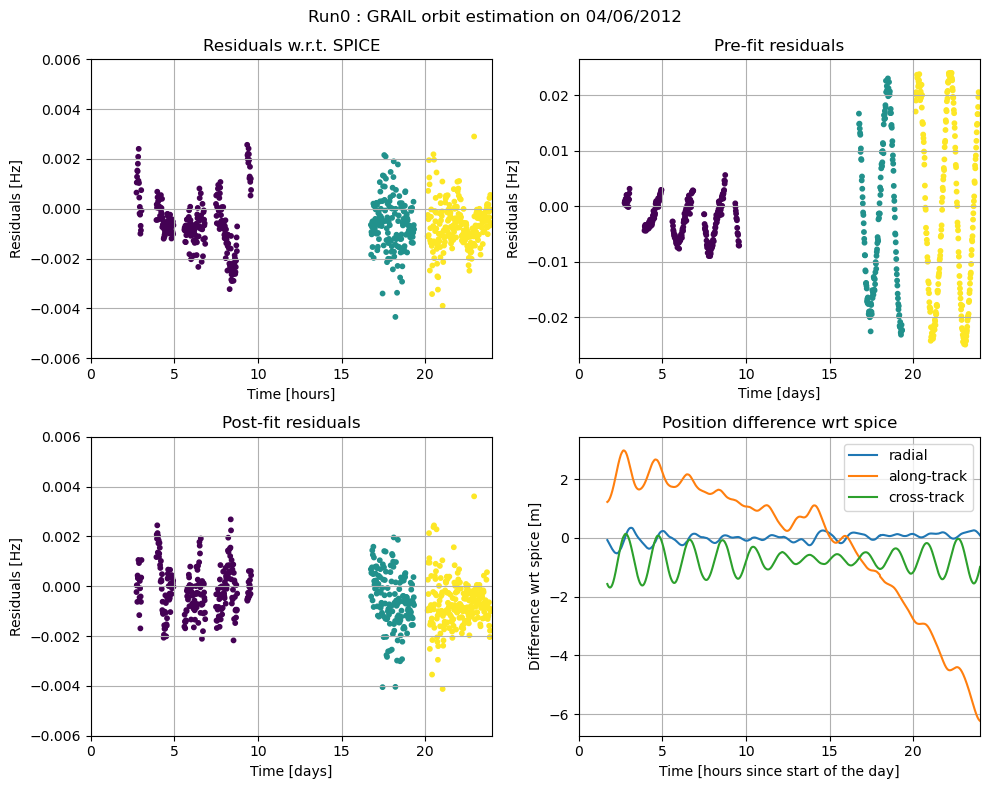

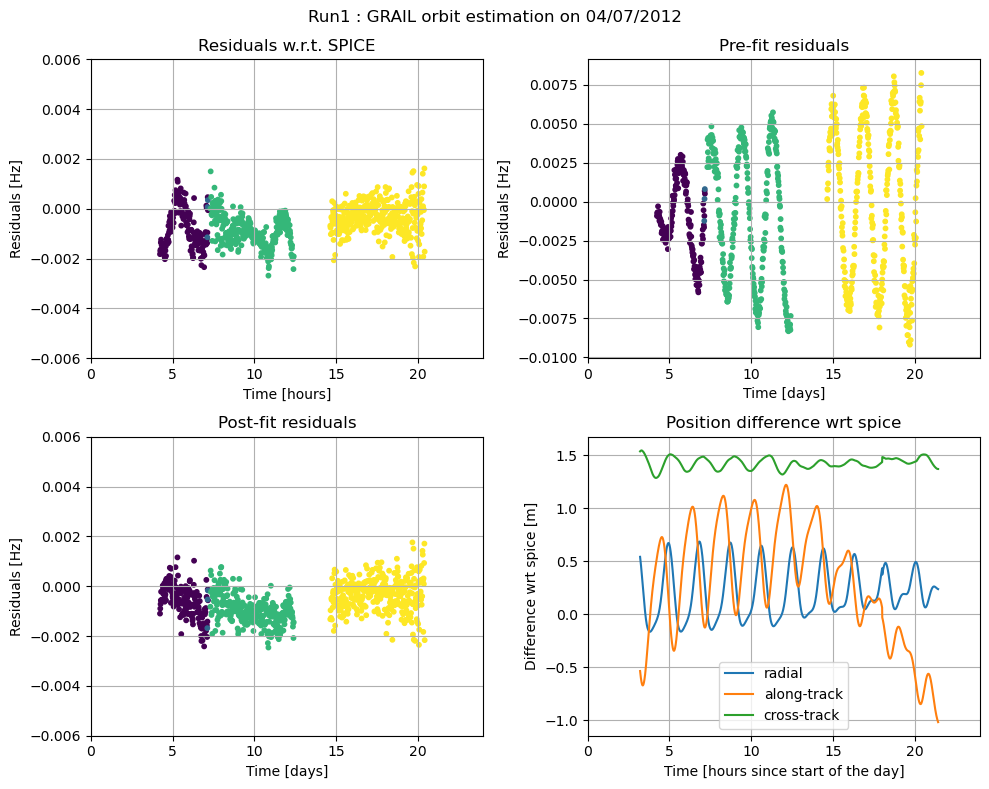

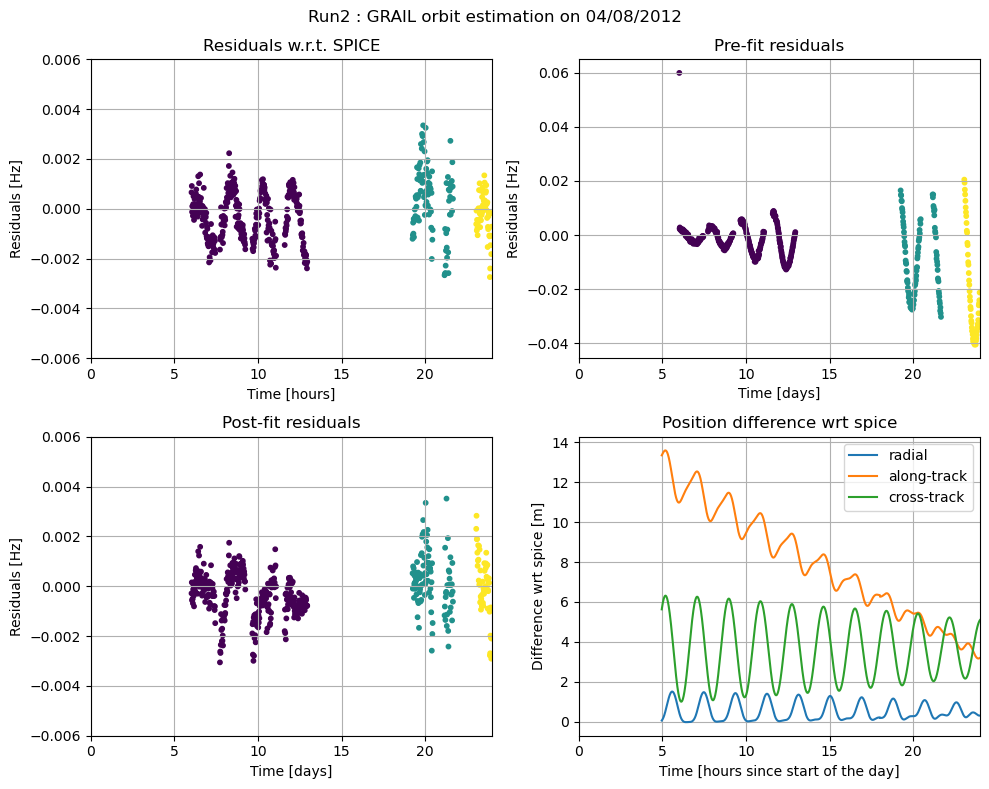

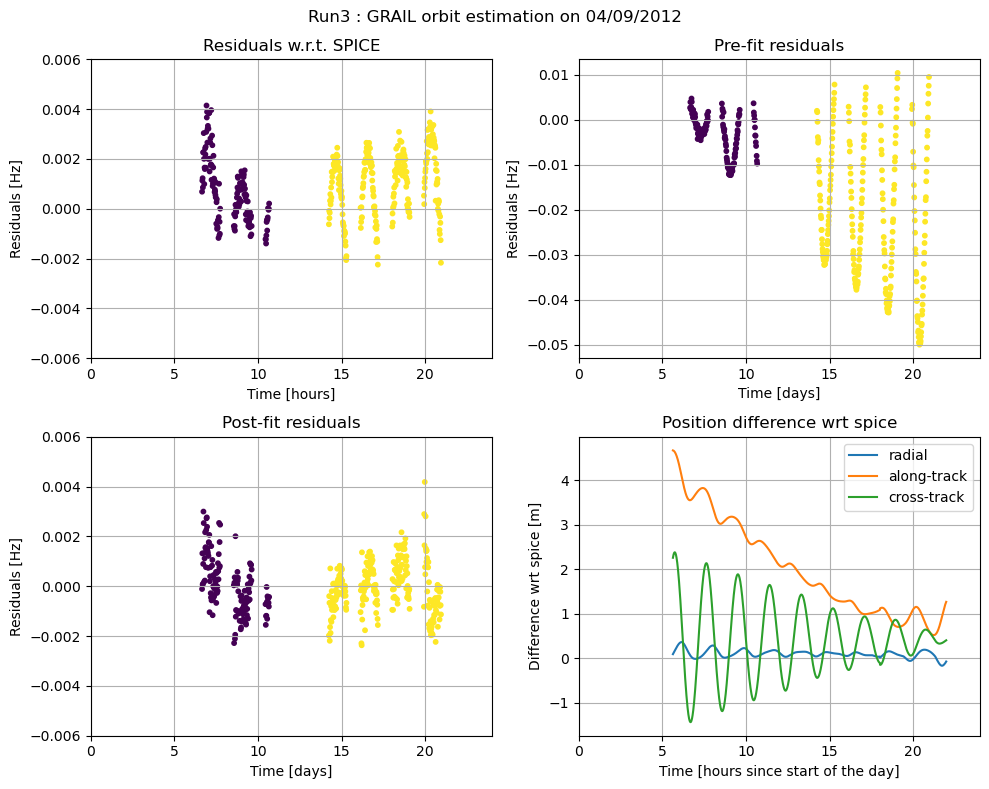

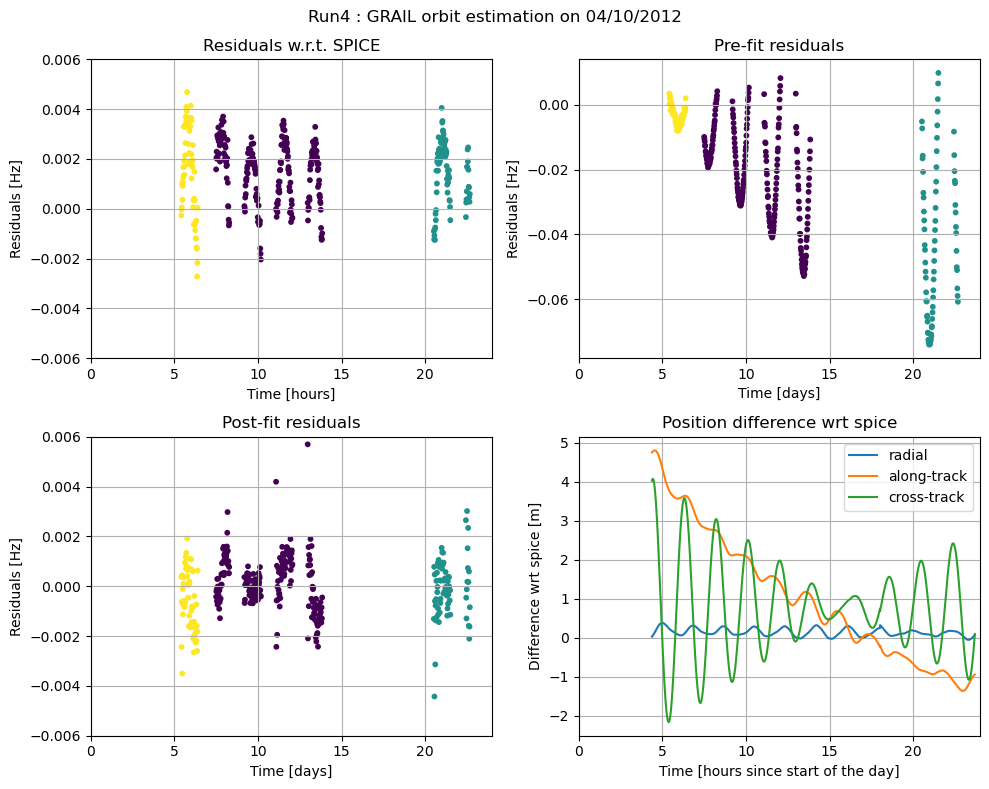

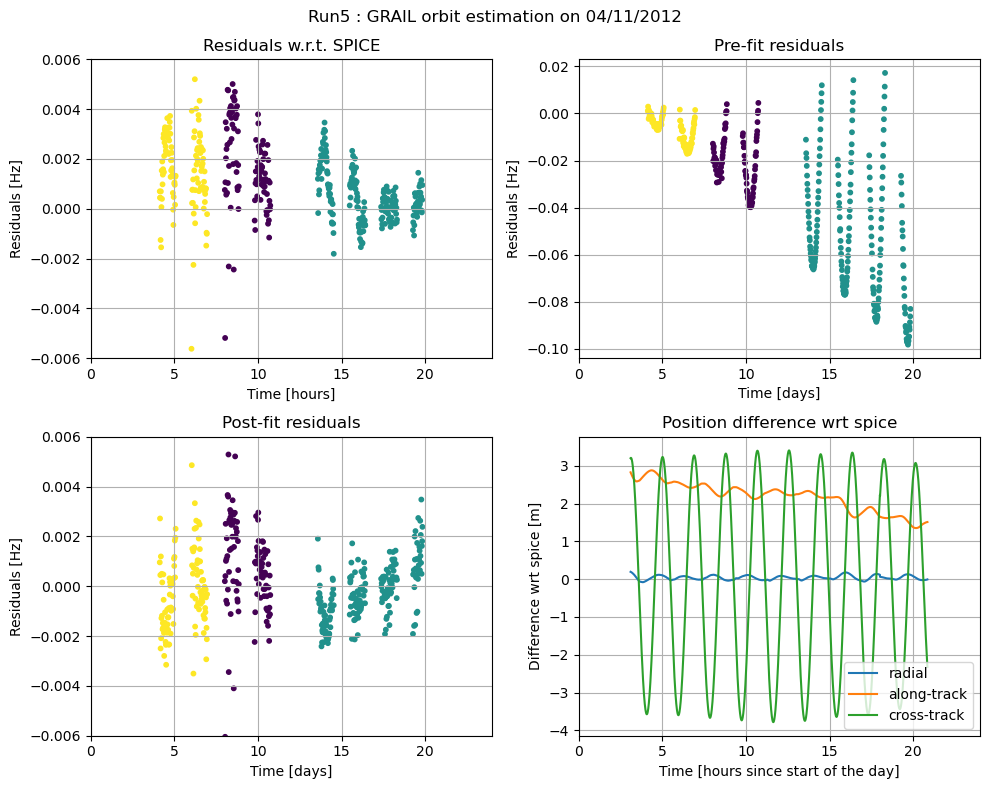

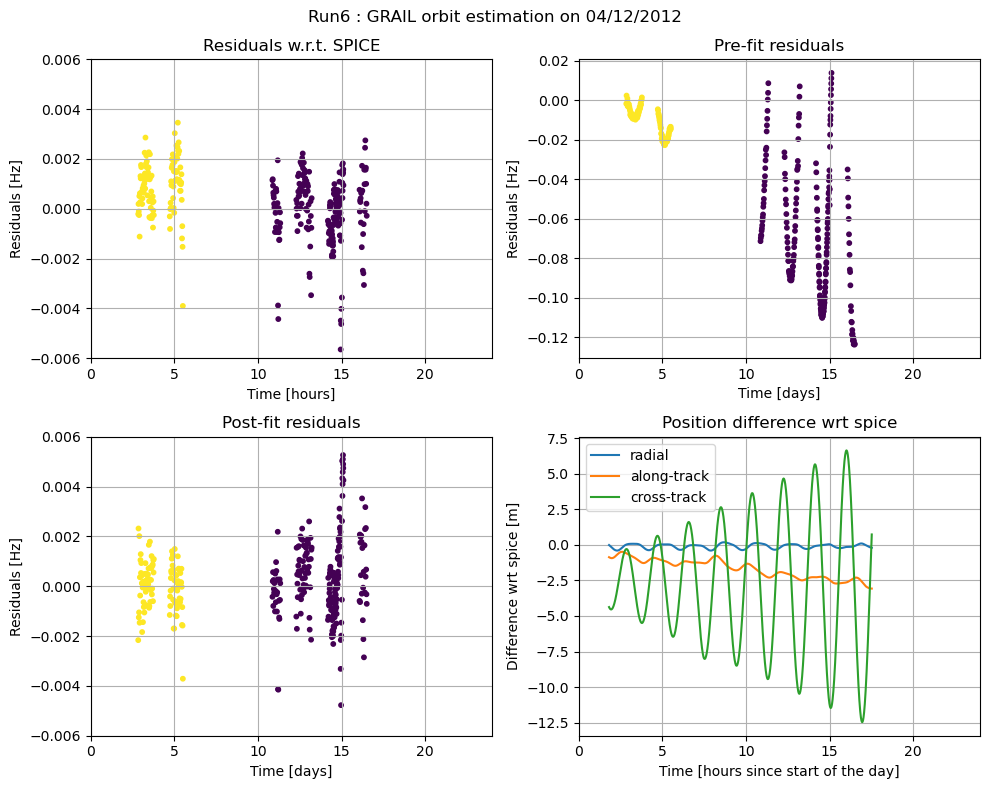

In [2]:
def run_odf_estimation(inputs):

    # Unpack various input arguments
    input_index = inputs[0]

    # Convert the datetime object defining the day of interest to a Tudat Time variable.
    date = time_representation.DateTime.from_python_datetime(inputs[1]).to_epoch()

    # Retrieve lists of relevant kernels and input files to load (ODF files, clock and orientation kernels for GRAIL,
    # tropospheric and ionospheric corrections, manoeuvres file, antennas switch files, GRAIL trajectory files, GRAIL
    # reference frames file, lunar orientation kernels, and lunar reference frame kernel)
    odf_files = inputs[2]
    clock_file = inputs[3]
    grail_orientation_files = inputs[4]
    tro_files = inputs[5]
    ion_files = inputs[6]
    manoeuvre_file = inputs[7]
    antennas_switch_files = inputs[8]
    trajectory_files = inputs[9]
    grail_ref_frames_file = inputs[10]
    lunar_orientation_file = inputs[11]
    lunar_ref_frame_file = inputs[12]
    output_folder = inputs[13]

    # Redirect the outputs of this run to a file names grail_odf_estimation_output_x.dat, with x the run index
    with util.redirect_std(
        output_folder + "grail_odf_estimation_output_" + str(input_index) + ".dat",
        True,
        True,
    ):

        print("input_index", input_index)

        filename_suffix = str(input_index)

        ### ------------------------------------------------------------------------------------------
        ### LOAD ALL REQUESTED KERNELS AND FILES
        ### ------------------------------------------------------------------------------------------

        # Load standard spice kernels
        spice.load_standard_kernels()

        # Load specific Moon kernels
        spice.load_kernel(lunar_ref_frame_file)
        spice.load_kernel(lunar_orientation_file)

        # Load GRAIL frame definition file (useful for spacecraft-fixed frames definition)
        spice.load_kernel(grail_ref_frames_file)

        # Load GRAIL orientation kernels (over the entire relevant time period).
        for orientation_file in grail_orientation_files:
            spice.load_kernel(orientation_file)

        # Load GRAIL clock file
        spice.load_kernel(clock_file)

        # Load GRAIL trajectory kernel
        for trajectory_file in trajectory_files:
            spice.load_kernel(trajectory_file)

        ### ------------------------------------------------------------------------------------------
        ### LOAD ODF OBSERVATIONS AND PERFORM PRE-PROCESSING STEPS
        ### ------------------------------------------------------------------------------------------

        if not odf_files:
            odf_files = ["grail_kernels/gralugf2012_097_0235smmmv1.odf"]

        # Load ODF files
        multi_odf_file_contents = (
            observations_setup.observations_wrapper.process_odf_data_multiple_files(
                odf_files, "GRAIL-A", True
            )
        )

        # Create observation collection from ODF files, only retaining Doppler observations. An observation collection contains
        # multiple "observation sets". Within a given observation set, the observables are of the same type (here Doppler) and
        # defined from the same link ends. However, within the "global" observation collection, multiple observation sets can
        # typically be found for a given observable type and link ends, but they will cover different observation time intervals.
        # When loading ODF data, a separate observation set is created for each ODF file (which means the time intervals of each
        # set match those of the corresponding ODF file).
        original_odf_observations = observations_setup.observations_wrapper.create_odf_observed_observation_collection(
            multi_odf_file_contents,
            [observable_models_setup.model_settings.dsn_n_way_averaged_doppler_type],
            [
                time_representation.Time(0, np.nan),
                time_representation.Time(0, np.nan),
            ],
        )

        # Filter all ODF observations that exceed the arc duration of one day
        day_arc_filter = observations.observations_processing.observation_filter(
            observations.observations_processing.ObservationFilterType.time_bounds_filtering,
            date,
            date + 86400.0,
            use_opposite_condition=True,
        )
        original_odf_observations.filter_observations(day_arc_filter)
        original_odf_observations.remove_empty_observation_sets()

        # Retrieve time bounds of the ODF observations. A time buffer of 1h is subtracted/added to the observation
        # start and end times. This is necessary to ensure that the simulation environment covers the full time span of the
        # loaded ODF observations, without interpolation errors at the arc boundaries.
        observation_time_limits = original_odf_observations.time_bounds_time_object
        obs_start_time = observation_time_limits[0] - 3600.0
        obs_end_time = observation_time_limits[1] + 3600.0

        print(
            "Original observations: ",
            original_odf_observations.concatenated_observations.size,
        )
        original_odf_observations.print_observation_sets_start_and_size()

        # Compress Doppler observations from 1.0 s integration time to 60.0 s
        compressed_observations = observations_setup.observations_wrapper.create_compressed_doppler_collection(
            original_odf_observations, 60, 10
        )
        print(
            "Compressed observations: ",
            compressed_observations.concatenated_observations.size,
        )
        compressed_observations.print_observation_sets_start_and_size()

        ### ------------------------------------------------------------------------------------------
        ### CREATE DYNAMICAL ENVIRONMENT
        ### ------------------------------------------------------------------------------------------

        # Create default body settings for celestial bodies
        bodies_to_create = [
            "Earth",
            "Sun",
            "Mercury",
            "Venus",
            "Mars",
            "Jupiter",
            "Saturn",
            "Moon",
        ]
        global_frame_origin = "SSB"
        global_frame_orientation = "J2000"
        body_settings = environment_setup.get_default_body_settings_time_limited(
            bodies_to_create,
            obs_start_time.to_float(),
            obs_end_time.to_float(),
            global_frame_origin,
            global_frame_orientation,
        )

        # Modify default shape, rotation, and gravity field settings for the Earth
        body_settings.get("Earth").shape_settings = (
            environment_setup.shape.oblate_spherical_spice()
        )
        body_settings.get("Earth").rotation_model_settings = (
            environment_setup.rotation_model.gcrs_to_itrs(
                environment_setup.rotation_model.iau_2006,
                global_frame_orientation,
                interpolators.interpolator_generation_settings(
                    interpolators.cubic_spline_interpolation(),
                    obs_start_time.to_float(),
                    obs_end_time.to_float(),
                    3600.0,
                ),
                interpolators.interpolator_generation_settings(
                    interpolators.cubic_spline_interpolation(),
                    obs_start_time.to_float(),
                    obs_end_time.to_float(),
                    3600.0,
                ),
                interpolators.interpolator_generation_settings(
                    interpolators.cubic_spline_interpolation(),
                    obs_start_time.to_float(),
                    obs_end_time.to_float(),
                    60.0,
                ),
            )
        )
        body_settings.get("Earth").gravity_field_settings.associated_reference_frame = (
            "ITRS"
        )

        # Set up DSN ground stations
        body_settings.get("Earth").ground_station_settings = (
            environment_setup.ground_station.dsn_stations()
        )

        # Modify default rotation and gravity field settings for the Moon
        body_settings.get("Moon").rotation_model_settings = (
            environment_setup.rotation_model.spice(
                global_frame_orientation, "MOON_PA_DE440", "MOON_PA_DE440"
            )
        )
        body_settings.get("Moon").gravity_field_settings = (
            environment_setup.gravity_field.predefined_spherical_harmonic(
                environment_setup.gravity_field.gggrx1200, 500
            )
        )
        body_settings.get("Moon").gravity_field_settings.associated_reference_frame = (
            "MOON_PA_DE440"
        )

        # Define gravity field variations for the tides on the Moon
        moon_gravity_field_variations = list()
        moon_gravity_field_variations.append(
            environment_setup.gravity_field_variation.solid_body_tide(
                "Earth", 0.02405, 2
            )
        )
        moon_gravity_field_variations.append(
            environment_setup.gravity_field_variation.solid_body_tide("Sun", 0.02405, 2)
        )
        body_settings.get("Moon").gravity_field_variation_settings = (
            moon_gravity_field_variations
        )
        body_settings.get("Moon").ephemeris_settings.frame_origin = "Earth"

        # Add Moon radiation properties
        moon_surface_radiosity_models = [
            radiation_pressure.thermal_emission_angle_based_radiosity(
                95.0, 385.0, 0.95, "Sun"
            ),
            radiation_pressure.variable_albedo_surface_radiosity(
                radiation_pressure.predefined_spherical_harmonic_surface_property_distribution(
                    radiation_pressure.albedo_dlam1
                ),
                "Sun",
            ),
        ]
        body_settings.get("Moon").radiation_source_settings = (
            radiation_pressure.panelled_extended_radiation_source(
                moon_surface_radiosity_models, [6, 12]
            )
        )

        # Create empty settings for the GRAIL spacecraft
        spacecraft_name = "GRAIL-A"
        spacecraft_central_body = "Moon"
        body_settings.add_empty_settings(spacecraft_name)
        body_settings.get(spacecraft_name).constant_mass = 221.69

        # Define translational ephemeris from SPICE
        body_settings.get(spacecraft_name).ephemeris_settings = (
            environment_setup.ephemeris.interpolated_spice(
                obs_start_time.to_float(),
                obs_end_time.to_float(),
                10.0,
                spacecraft_central_body,
                global_frame_orientation,
            )
        )

        # Define rotational ephemeris from SPICE
        body_settings.get(spacecraft_name).rotation_model_settings = (
            environment_setup.rotation_model.spice(
                global_frame_orientation, spacecraft_name + "_SPACECRAFT", ""
            )
        )

        # Define GRAIL panel geometry, which will be used for the panel radiation pressure model
        body_settings.get(spacecraft_name).vehicle_shape_settings = (
            get_grail_panel_geometry()
        )

        # Create environment
        bodies = environment_setup.create_system_of_bodies(body_settings)

        # Add radiation pressure target models for GRAIL (cannonball model for the solar radiation pressure,
        # and complete panel model for the radiation pressure from the Moon)
        occulting_bodies = dict()
        occulting_bodies["Sun"] = ["Earth"]
        pixel_source = {"Sun": 0, "Moon": 0}  # No self-shadowing
        environment_setup.add_radiation_pressure_target_model(
            bodies,
            spacecraft_name,
            radiation_pressure.panelled_radiation_target(
                occulting_bodies, pixel_source
            ),
        )

        # Update bodies based on ODF file. This step is necessary to set the antenna transmission frequencies for the GRAIL spacecraft
        observations_setup.observations_wrapper.set_odf_information_in_bodies(
            multi_odf_file_contents, bodies
        )

        ### ------------------------------------------------------------------------------------------
        ### SET ANTENNA AS REFERENCE POINT FOR DOPPLER OBSERVATIONS
        ### ------------------------------------------------------------------------------------------

        # Load GRAIL's antenna switch files. For each day, the corresponding file contains the position history of the antenna used for
        # radio tracking. As such, they keep track of all switches between the two GRAIL antennas that might have occurred during that
        # day. The GRAIL's antenna positions are provided in the spacecraft-fixed frame.
        antenna_switch_times = []
        antenna_switch_positions = []
        for file in antennas_switch_files:
            antenna_switch_times += grail_antenna_file_reader(file)[0]
            antenna_switch_positions += grail_antenna_file_reader(file)[1]

        # Reconstruct dictionary containing the antenna switch history (including the GRAIL-fixed position of the relevant antenna at
        # initial and final times)
        antenna_switch_history = dict()
        antenna_switch_history[obs_start_time.to_float()] = np.array(
            antenna_switch_positions[0:3]
        )
        for k in range(len(antenna_switch_times)):
            antenna_switch_history[antenna_switch_times[k]] = np.array(
                antenna_switch_positions[k * 3 : (k + 1) * 3]
            )
        antenna_switch_history[obs_end_time.to_float()] = np.array(
            antenna_switch_positions[-3:]
        )

        # Set GRAIL's reference point position to follow the antenna switch history (the antennas' positions should be provided in the
        # spacecraft-fixed frame)
        compressed_observations.set_reference_points(
            bodies,
            antenna_switch_history,
            spacecraft_name,
            observable_models_setup.links.LinkEndType.reflector1,
        )

        ### ------------------------------------------------------------------------------------------
        ### RETRIEVE GRAIL MANOEUVRES EPOCHS
        ### ------------------------------------------------------------------------------------------

        # Load the times at which the spacecraft underwent a manoeuvre from GRAIL's manoeuvres file
        manoeuvres_times = grail_mass_level_0_file_reader(manoeuvre_file)

        # Store the manoeuvres epochs if they occur within the time interval under consideration
        relevant_manoeuvres = []
        for manoeuvre_time in manoeuvres_times:
            if (
                manoeuvre_time >= obs_start_time.to_float()
                and manoeuvre_time <= obs_end_time.to_float()
            ):
                relevant_manoeuvres.append(manoeuvre_time)

        # Save list of manoeuvre epochs occurring within the time interval under consideration
        np.savetxt(
            output_folder + "relevant_manoeuvres_" + filename_suffix + ".dat",
            relevant_manoeuvres,
            delimiter=",",
        )

        ### ------------------------------------------------------------------------------------------
        ### DEFINE PROPAGATION SETTINGS
        ### ------------------------------------------------------------------------------------------

        # Define list of accelerations acting on GRAIL
        accelerations_settings_spacecraft = dict(
            Sun=[
                propagation_setup.acceleration.radiation_pressure(
                    environment_setup.radiation_pressure.paneled_target
                ),
                propagation_setup.acceleration.point_mass_gravity(),
            ],
            Earth=[propagation_setup.acceleration.point_mass_gravity()],
            Moon=[
                propagation_setup.acceleration.spherical_harmonic_gravity(256, 256),
                propagation_setup.acceleration.radiation_pressure(
                    environment_setup.radiation_pressure.paneled_target
                ),
                propagation_setup.acceleration.empirical(),
            ],
            Mars=[propagation_setup.acceleration.point_mass_gravity()],
            Venus=[propagation_setup.acceleration.point_mass_gravity()],
            Jupiter=[propagation_setup.acceleration.point_mass_gravity()],
            Saturn=[propagation_setup.acceleration.point_mass_gravity()],
        )

        # Add manoeuvres if necessary
        if len(relevant_manoeuvres) > 0:
            accelerations_settings_spacecraft[spacecraft_name] = [
                propagation_setup.acceleration.quasi_impulsive_shots_acceleration(
                    relevant_manoeuvres, [np.zeros((3, 1))], 3600.0, 60.0
                )
            ]

        # Create accelerations settings dictionary
        acceleration_settings = {spacecraft_name: accelerations_settings_spacecraft}

        # Create acceleration models from settings
        bodies_to_propagate = [spacecraft_name]
        central_bodies = [spacecraft_central_body]
        acceleration_models = propagation_setup.create_acceleration_models(
            bodies, acceleration_settings, bodies_to_propagate, central_bodies
        )

        # Define integrator settings
        integration_step = 30.0
        integrator_settings = propagation_setup.integrator.runge_kutta_fixed_step_size(
            time_representation.Time(0, integration_step),
            propagation_setup.integrator.rkf_78,
        )

        # Retrieve GRAIL initial state from SPICE
        initial_state = propagation.get_state_of_bodies(
            bodies_to_propagate, central_bodies, bodies, obs_start_time
        )

        # Define propagator settings
        propagator_settings = propagation_setup.propagator.translational(
            central_bodies,
            acceleration_models,
            bodies_to_propagate,
            initial_state,
            obs_start_time,
            integrator_settings,
            propagation_setup.propagator.time_termination(obs_end_time.to_float()),
        )
        propagator_settings.print_settings.results_print_frequency_in_steps = (
            3600.0 / integration_step
        )

        ### ------------------------------------------------------------------------------------------
        ### DEFINE SETTINGS TO SIMULATE OBSERVATIONS AND COMPUTE RESIDUALS
        ### ------------------------------------------------------------------------------------------

        # Create light-time corrections list
        light_time_correction_list = list()
        light_time_correction_list.append(
            observable_models_setup.light_time_corrections.first_order_relativistic_light_time_correction(
                ["Sun"]
            )
        )

        # Add tropospheric correction
        light_time_correction_list.append(
            observable_models_setup.light_time_corrections.dsn_tabulated_tropospheric_light_time_correction(
                tro_files
            )
        )

        # Add ionospheric correction
        spacecraft_name_per_id = dict()
        spacecraft_name_per_id[177] = "GRAIL-A"
        light_time_correction_list.append(
            observable_models_setup.light_time_corrections.dsn_tabulated_ionospheric_light_time_correction(
                ion_files, spacecraft_name_per_id
            )
        )

        # Create observation model settings for the Doppler observables. This first implies creating the link ends defining all relevant
        # tracking links between various ground stations and the MRO spacecraft. The list of light-time corrections defined above is then
        # added to each of these link ends.
        doppler_link_ends = compressed_observations.link_definitions_per_observable[
            estimation.observable_models_setup.model_settings.dsn_n_way_averaged_doppler_type
        ]

        observation_model_settings = list()
        for current_link_definition in doppler_link_ends:
            observation_model_settings.append(
                observable_models_setup.model_settings.dsn_n_way_doppler_averaged(
                    current_link_definition, light_time_correction_list
                )
            )

        # Create observation simulators
        observation_simulators = observations_setup.observations_simulation_settings.create_observation_simulators(
            observation_model_settings, bodies
        )

        # Compute and set residuals in the compressed observation collection
        estimation.observations.compute_residuals_and_dependent_variables(
            compressed_observations, observation_simulators, bodies
        )

        # Filter residual outliers
        compressed_observations.filter_observations(
            estimation.observations.observations_processing.observation_filter(
                estimation.observations.observations_processing.ObservationFilterType.residual_filtering,
                0.1,
            )
        )

        # Save residuals as directly computed w.r.t. the reference SPICE trajectory for GRAIL, along with the
        # observation times and link ends IDs.
        np.savetxt(
            output_folder + "residuals_wrt_spice_" + filename_suffix + ".dat",
            compressed_observations.get_concatenated_residuals(),
            delimiter=",",
        )
        np.savetxt(
            output_folder + "observation_times_" + filename_suffix + ".dat",
            compressed_observations.concatenated_times,
            delimiter=",",
        )
        np.savetxt(
            output_folder + "link_end_ids_" + filename_suffix + ".dat",
            compressed_observations.concatenated_link_definition_ids,
            delimiter=",",
        )

        linkEndsDict = compressed_observations.link_definition_ids
        link_ends_ids = compressed_observations.concatenated_link_definition_ids
        link_ends_names = [
            linkEndsDict[linkId][
                observable_models_setup.links.LinkEndType.transmitter
            ].reference_point
            + " - "
            + linkEndsDict[linkId][
                observable_models_setup.links.LinkEndType.receiver
            ].reference_point
            for linkId in link_ends_ids
        ]
        np.savetxt(
            output_folder + "link_end_names_" + filename_suffix + ".dat",
            link_ends_names,
            fmt="%s",  # Format as string
            delimiter="\n",  # Each string on a new line
        )

        ### ------------------------------------------------------------------------------------------
        ### DEFINE SET OF PARAMETERS TO BE ESTIMATED
        ### ------------------------------------------------------------------------------------------

        # Define parameters to estimate
        parameter_settings = parameters_setup.initial_states(
            propagator_settings, bodies
        )

        # Define list of additional parameters
        extra_parameters = [
            parameters_setup.radiation_pressure_target_direction_scaling(
                spacecraft_name, "Sun"
            ),
            parameters_setup.radiation_pressure_target_perpendicular_direction_scaling(
                spacecraft_name, "Sun"
            ),
            parameters_setup.radiation_pressure_target_direction_scaling(
                spacecraft_name, "Moon"
            ),
            parameters_setup.radiation_pressure_target_perpendicular_direction_scaling(
                spacecraft_name, "Moon"
            ),
        ]

        # Include the estimation of the manoeuvres if any are detected during the arc of interest
        if len(relevant_manoeuvres) > 0:
            extra_parameters.append(
                parameters_setup.quasi_impulsive_shots(spacecraft_name)
            )

        # Add additional parameters settings
        parameter_settings += extra_parameters

        # Create set of parameters to estimate
        parameters_to_estimate = parameters_setup.create_parameter_set(
            parameter_settings, bodies, propagator_settings
        )
        parameters.print_parameter_names(parameters_to_estimate)

        print("pre-fit parameters values", parameters_to_estimate.parameter_vector)

        ### ------------------------------------------------------------------------------------------
        ### DEFINE ESTIMATION SETTINGS AND PERFORM THE FIT
        ### ------------------------------------------------------------------------------------------

        # Create estimator
        estimator = estimation_analysis.Estimator(
            bodies,
            parameters_to_estimate,
            observation_model_settings,
            propagator_settings,
        )

        # Define estimation settings
        estimation_input = estimation.estimation_analysis.EstimationInput(
            compressed_observations,
            convergence_checker=estimation.estimation_analysis.estimation_convergence_checker(
                2
            ),
        )
        estimation_input.define_estimation_settings(
            reintegrate_equations_on_first_iteration=False,
            reintegrate_variational_equations=False,
            print_output_to_terminal=True,
            save_state_history_per_iteration=True,
        )

        # Perform estimation
        estimation_output = estimator.perform_estimation(estimation_input)

        # Save pre- and post-fit residuals
        np.savetxt(
            output_folder + "prefit_residuals_" + filename_suffix + ".dat",
            estimation_output.residual_history[:, 0],
            delimiter=",",
        )
        np.savetxt(
            output_folder + "postfit_residuals_" + filename_suffix + ".dat",
            estimation_output.residual_history[:, -1],
            delimiter=",",
        )

        # Retrieve the post-fit state history of GRAIL
        estimated_state_history = estimation_output.simulation_results_per_iteration[
            -1
        ].dynamics_results.state_history

        # Print estimated parameters values
        print("post-fit estimated parameters", parameters_to_estimate.parameter_vector)

        # Compute the difference between GRAIL's post-fit state history as estimated in this example and its reference spice
        # trajectory, in the RSW frame (radial, along-track, cross-track).
        rsw_state_difference = get_rsw_state_difference(
            estimated_state_history,
            spacecraft_name,
            spacecraft_central_body,
            global_frame_orientation,
        )

        # Save RSW state difference w.r.t. spice trajectory
        np.savetxt(
            output_folder + "postfit_rsw_state_difference_" + filename_suffix + ".dat",
            rsw_state_difference,
            delimiter=",",
        )


if __name__ == "__main__":
    print("Start")
    inputs = []

    output_folder = "grail_estimation_output/"
    if not os.path.isdir(output_folder):
        os.mkdir(output_folder)

    # Specify the number of parallel runs to use for this example
    nb_parallel_runs = 7

    # Define dates for the five arcs to be analysed in parallel (we only include dates for which an ODF file is available).
    # Each parallel run will therefore parse a single day-long arc.
    dates = [
        datetime(2012, 4, 6),
        datetime(2012, 4, 7),
        datetime(2012, 4, 8),
        datetime(2012, 4, 9),
        datetime(2012, 4, 10),
        datetime(2012, 4, 11),
        datetime(2012, 4, 12),
    ]

    # For each parallel run
    for i in range(nb_parallel_runs):

        # First retrieve the names of all the relevant kernels and data files necessary to cover the date of interest
        (
            clock_file,
            grail_orientation_files,
            tro_files,
            ion_files,
            manoeuvres_file,
            antenna_files,
            odf_files,
            trajectory_files,
            grail_frames_def_file,
            moon_orientation_file,
            lunar_frame_file,
        ) = get_grail_files("grail_kernels/", dates[i], dates[i])
        print(dates[i])
        print(manoeuvres_file)

        # Construct a list of input arguments containing the arguments needed this specific run.
        # These include the date of interest, along with the names of all relevant kernels and data files that should be loaded
        inputs.append(
            [
                i,
                dates[i],
                odf_files,
                clock_file,
                grail_orientation_files,
                tro_files,
                ion_files,
                manoeuvres_file,
                antenna_files,
                trajectory_files,
                grail_frames_def_file,
                moon_orientation_file,
                lunar_frame_file,
                output_folder,
            ]
        )

    # Run parallel GRAIL estimations from ODF data
    print("---------------------------------------------")
    print(
        "The output of each parallel estimation is saved in a separate file named grail_odf_estimation_output_x.dat, "
        "with x the index of the run (all output files are saved in " + output_folder
    )
    with mp.get_context("fork").Pool(nb_parallel_runs) as pool:
        pool.map(run_odf_estimation, inputs)

    all_prefit = []
    all_times = []
    all_link_ends = []
    all_postfit = []
    all_residuals_wrt_spice = []
    # Load and plot the results of each parallel estimation
    for i in range(nb_parallel_runs):
        obs_times = np.loadtxt(output_folder + "observation_times_" + str(i) + ".dat")
        link_ends_ids = np.loadtxt(output_folder + "link_end_ids_" + str(i) + ".dat")
        residuals_wrt_spice = np.loadtxt(
            output_folder + "residuals_wrt_spice_" + str(i) + ".dat"
        )
        prefit_residuals = np.loadtxt(
            output_folder + "prefit_residuals_" + str(i) + ".dat"
        )
        postfit_residuals = np.loadtxt(
            output_folder + "postfit_residuals_" + str(i) + ".dat"
        )
        difference_rsw_wrt_spice = np.loadtxt(
            output_folder + "postfit_rsw_state_difference_" + str(i) + ".dat",
            delimiter=",",
        )
        link_ends_names = np.loadtxt(
            output_folder + "link_end_names_" + str(i) + ".dat", dtype=str
        )

        all_times.append(obs_times)
        all_link_ends.append(link_ends_names)
        all_prefit.append(prefit_residuals)
        all_postfit.append(postfit_residuals)

        start_date = time_representation.DateTime.from_python_datetime(dates[i]).to_epoch()

        # Plot the results of the current estimation.
        fig, axs = plt.subplots(2, 2, figsize=(10, 8))

        # Plot residuals wrt reference spice trajectory
        axs[0, 0].scatter(
            (obs_times - start_date) / 3600, residuals_wrt_spice, c=link_ends_ids, s=10
        )
        axs[0, 0].grid()
        axs[0, 0].set_ylim([-0.006, 0.006])
        axs[0, 0].set_xlim([0, 24])
        axs[0, 0].set_xlabel("Time [hours]")
        axs[0, 0].set_ylabel("Residuals [Hz]")
        axs[0, 0].set_title("Residuals w.r.t. SPICE")

        # Plot pre-fit residuals
        axs[0, 1].scatter(
            (obs_times - start_date) / 3600, prefit_residuals, c=link_ends_ids, s=10
        )
        axs[0, 1].grid()
        axs[0, 1].set_xlim([0, 24])
        axs[0, 1].set_xlabel("Time [days]")
        axs[0, 1].set_ylabel("Residuals [Hz]")
        axs[0, 1].set_title("Pre-fit residuals")

        # Plot post-fit residuals
        axs[1, 0].scatter(
            (obs_times - start_date) / 3600, postfit_residuals, c=link_ends_ids, s=10
        )
        axs[1, 0].grid()
        axs[1, 0].set_ylim([-0.006, 0.006])
        axs[1, 0].set_xlim([0, 24])
        axs[1, 0].set_xlabel("Time [days]")
        axs[1, 0].set_ylabel("Residuals [Hz]")
        axs[1, 0].set_title("Post-fit residuals")

        # Plot the difference between the reconstructed GRAIL trajectory and the reference spice kernel, in RSW frame
        axs[1, 1].plot(
            (difference_rsw_wrt_spice[:, 0] - start_date) / 3600,
            difference_rsw_wrt_spice[:, 1],
            label="radial",
        )
        axs[1, 1].plot(
            (difference_rsw_wrt_spice[:, 0] - start_date) / 3600,
            difference_rsw_wrt_spice[:, 2],
            label="along-track",
        )
        axs[1, 1].plot(
            (difference_rsw_wrt_spice[:, 0] - start_date) / 3600,
            difference_rsw_wrt_spice[:, 3],
            label="cross-track",
        )
        axs[1, 1].grid()
        axs[1, 1].set_xlim([0, 24])
        axs[1, 1].set_xlabel("Time [hours since start of the day]")
        axs[1, 1].set_ylabel("Difference wrt spice [m]")
        axs[1, 1].set_title("Position difference wrt spice")
        axs[1, 1].legend()

        fig.suptitle(
            "Run"
            + str(i)
            + " : "
            + "GRAIL orbit estimation on "
            + dates[i].strftime("%m/%d/%Y")
        )
        fig.tight_layout()

        plt.show()